In [4]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
import torchvision
import numpy as np
from torch.utils import data as tdata
from torch import nn
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.ndimage import filters
import time
import os
from itertools import product
smooth = filters.uniform_filter1d

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import shutil

shutil.copytree('/content/drive/My Drive/Colab Notebooks/Datasets', 'Datasets')

'Datasets'

In [7]:
#importing the dataset
df = pd.read_csv('Datasets/icml_face_data.csv')
df.columns = ['emotion', 'Usage', 'pixels']

#Indices for the training and test sets
usage = df['Usage'].values
trainIndices = np.nonzero(usage == 'Training')[0]
testIndices = np.nonzero(usage == 'PublicTest')[0]

device = torch.device("cuda:0")
random_seed = 123
num_classes = 7
num_epochs = 30
batch_size = 64

In [8]:
#Making the data able to be modeled(the column pixels initially an object instead of an array or tensor)
def prepare_data(data):
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    #turn the pixels column into arrays of integers
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

#Put the dataframe through function, then change emotion and pixels to tensors
pixels, emotion = prepare_data(df)
emotion = torch.tensor(emotion)
pixels = torch.tensor(pixels, dtype=torch.float32).reshape(-1,1,48,48)


#using the indices from earlier to make training set and test set
trainset = tdata.TensorDataset(pixels[trainIndices], emotion[trainIndices])
testset = tdata.TensorDataset(pixels[testIndices], emotion[testIndices])

In [9]:
#using training and test set to make loaders
trainLoader = tdata.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
testLoader = tdata.DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=False)

In [10]:
#code from the helper files on GitHub
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):            
        features = features.to(device)
        targets = targets.to(device)
        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100



def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)


def show_examples(model, data_loader, unnormalizer=None, class_dict=None):
    
        
    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)
    
    if unnormalizer is not None:
        for idx in range(features.shape[0]):
            features[idx] = unnormalizer(features[idx])
    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
    
    if nhwc_img.shape[-1] == 1:
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap='binary')
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False

    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhwc_img[idx])
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
        
    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        
        Returns:
        ------------
        Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

AlexNet

In [11]:
class AlexNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size = 11, stride = 4, padding = 2),
            torch.nn.ReLU(inplace = True),
            #torch.nn.MaxPool2d(kernel_size = 3, stride = 2),
            torch.nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
            torch.nn.ReLU(inplace = True),
            #torch.nn.MaxPool2d(kernel_size = 3, stride = 2),
            torch.nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
            torch.nn.ReLU(inplace = True),
            torch.nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
            torch.nn.ReLU(inplace = True),
            torch.nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            torch.nn.ReLU(inplace = True),
            #torch.nn.MaxPool2d(kernel_size = 3, stride = 2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace = True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace = True),
            torch.nn.Linear(4096, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

In [ ]:
torch.manual_seed(random_seed)
alex = AlexNet(num_classes)
alex.to(device)

optim_alex = torch.optim.Adam(alex.parameters(), lr = 3e-4)

for epoch in range(num_epochs):
    alex = alex.train()
    
    for batch_idx, (features, targets) in enumerate(trainLoader):
        features = features.to(device)
        targets = targets.to(device)
        logits = alex(features)
        cost = nn.functional.cross_entropy(logits, targets)
        optim_alex.zero_grad()
        cost.backward()
        optim_alex.step()
        if not batch_idx % 50:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' %
                  (epoch + 1, num_epochs, batch_idx,
                   len(trainset) // batch_size, cost))

    alex = alex.eval()

    with torch.set_grad_enabled(False):
      print('Epoch: %03d/%03d training accuracy: %.2f%%' %
            (epoch + 1, num_epochs, compute_accuracy(alex, trainLoader)))

Epoch: 001/030 | Batch 000/448 | Cost: 1.9883
Epoch: 001/030 | Batch 050/448 | Cost: 1.7726
Epoch: 001/030 | Batch 100/448 | Cost: 1.8606
Epoch: 001/030 | Batch 150/448 | Cost: 1.8008
Epoch: 001/030 | Batch 200/448 | Cost: 1.7393
Epoch: 001/030 | Batch 250/448 | Cost: 1.6638
Epoch: 001/030 | Batch 300/448 | Cost: 1.6211
Epoch: 001/030 | Batch 350/448 | Cost: 1.8224
Epoch: 001/030 | Batch 400/448 | Cost: 1.6944
Epoch: 001/030 training accuracy: 39.38%
Epoch: 002/030 | Batch 000/448 | Cost: 1.4696
Epoch: 002/030 | Batch 050/448 | Cost: 1.6304
Epoch: 002/030 | Batch 100/448 | Cost: 1.6783
Epoch: 002/030 | Batch 150/448 | Cost: 1.4396
Epoch: 002/030 | Batch 200/448 | Cost: 1.5318
Epoch: 002/030 | Batch 250/448 | Cost: 1.5644
Epoch: 002/030 | Batch 300/448 | Cost: 1.4757
Epoch: 002/030 | Batch 350/448 | Cost: 1.4117
Epoch: 002/030 | Batch 400/448 | Cost: 1.4391
Epoch: 002/030 training accuracy: 45.43%
Epoch: 003/030 | Batch 000/448 | Cost: 1.6214
Epoch: 003/030 | Batch 050/448 | Cost: 1.448

In [3]:
print('Test accuracy: %.2f%%' % (compute_accuracy(alex, testLoader)))

NameError: ignored

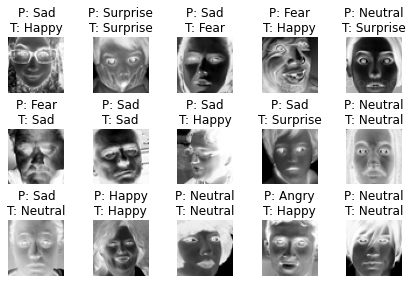

In [ ]:
alex.cpu()
unnormalizer = UnNormalize((0.1, 0.5, 0.5), (0.1, 0.5, 0.5))
class_dict = {0: 'Angry',
              1: 'Disgust',
              2: 'Fear',
              3: 'Happy',
              4: 'Sad',
              5: 'Surprise',
              6: 'Neutral'}

show_examples(model = alex, data_loader = testLoader, class_dict = class_dict)

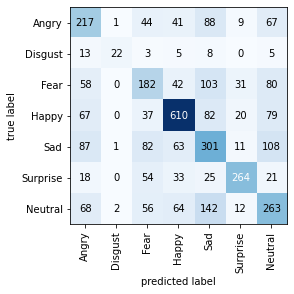

In [ ]:
mat_alex = compute_confusion_matrix(model = alex, data_loader = testLoader,
                                    device = torch.device('cpu'))
plot_confusion_matrix(mat_alex, class_names = class_dict.values())
plt.show()

VGG

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 7)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [ ]:
pixels_vgg, emotion = prepare_data(df)
emotion = torch.tensor(emotion)
pixels_vgg = torch.tensor(pixels_vgg, dtype=torch.float32).reshape(-1,48,48)
rgb_batch = np.repeat(pixels_vgg[..., np.newaxis], 3, -1)
rgb_batch = torch.tensor(rgb_batch,dtype=torch.float32).reshape(-1,3,48,48)
#using the indices from earlier to make training set and test set
trainset_vgg = tdata.TensorDataset(rgb_batch[trainIndices], emotion[trainIndices])
testset_vgg = tdata.TensorDataset(rgb_batch[testIndices], emotion[testIndices])
trainLoader_vgg= tdata.DataLoader(trainset_vgg, batch_size=batch_size, shuffle=True, drop_last=True)
testLoader_vgg = tdata.DataLoader(testset_vgg, batch_size=batch_size, shuffle=True, drop_last=False)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [ ]:
#Training the model
torch.manual_seed(random_seed)
model_vgg = VGG('VGG19')
model_vgg.to(device)

optimizer = torch.optim.Adam(model_vgg.parameters(), lr=3e-4)
num_epochs_vgg = 30
for epoch in range(num_epochs_vgg):
    model = model_vgg.train()
    for batch_idx, (features, targets) in enumerate(trainLoader_vgg):
        
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        cost = nn.functional.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()

        # Updating the model parameters
        optimizer.step()
        
        # Logging to see where it is in training
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs_vgg, batch_idx, 
                     len(trainset_vgg)//batch_size, cost))

    model = model_vgg.eval()

    # Show training accuracy after each epoch
    with torch.set_grad_enabled(False): 
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs_vgg, 
              compute_accuracy(model, trainLoader_vgg)))

Epoch: 001/030 | Batch 000/448 | Cost: 2.5135
Epoch: 001/030 | Batch 050/448 | Cost: 1.8054
Epoch: 001/030 | Batch 100/448 | Cost: 1.8641
Epoch: 001/030 | Batch 150/448 | Cost: 1.8883
Epoch: 001/030 | Batch 200/448 | Cost: 1.9381
Epoch: 001/030 | Batch 250/448 | Cost: 1.7405
Epoch: 001/030 | Batch 300/448 | Cost: 1.8267
Epoch: 001/030 | Batch 350/448 | Cost: 1.8431
Epoch: 001/030 | Batch 400/448 | Cost: 1.6272
Epoch: 001/030 training accuracy: 26.08%
Epoch: 002/030 | Batch 000/448 | Cost: 1.7698
Epoch: 002/030 | Batch 050/448 | Cost: 1.7630
Epoch: 002/030 | Batch 100/448 | Cost: 1.8134
Epoch: 002/030 | Batch 150/448 | Cost: 1.8454
Epoch: 002/030 | Batch 200/448 | Cost: 1.5592
Epoch: 002/030 | Batch 250/448 | Cost: 1.6860
Epoch: 002/030 | Batch 300/448 | Cost: 1.8111
Epoch: 002/030 | Batch 350/448 | Cost: 1.8133
Epoch: 002/030 | Batch 400/448 | Cost: 1.7795
Epoch: 002/030 training accuracy: 29.35%
Epoch: 003/030 | Batch 000/448 | Cost: 1.7563
Epoch: 003/030 | Batch 050/448 | Cost: 1.663

In [ ]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model_vgg, testLoader_vgg)))

Test accuracy: 45.31%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

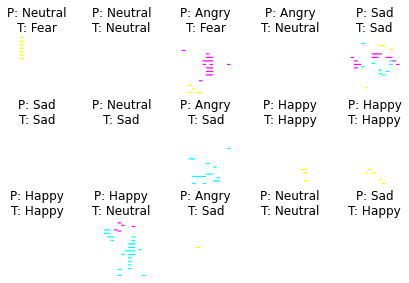

In [ ]:
model_vgg.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'Angry',
              1: 'Disgust',
              2: 'Fear',
              3: 'Happy',
              4: 'Sad',
              5: 'Surprise',
              6: 'Neutral'}

show_examples(model = model_vgg, data_loader = testLoader_vgg, class_dict = class_dict)

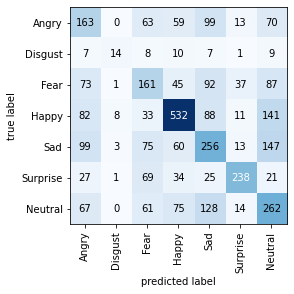

In [ ]:
mat_vgg = compute_confusion_matrix(model = model_vgg, data_loader = testLoader_vgg, device = torch.device('cpu'))
plot_confusion_matrix(mat_vgg, class_names=class_dict.values())
plt.show()

ResNet


In [ ]:
#setting up the residual blocks
class ResBlock(nn.Module):

    def __init__(self, channels, stride):
        
        super(ResBlock, self).__init__()
        
        self.block = nn.Sequential(
                nn.Conv2d(in_channels=channels[0],
                                out_channels=channels[1],
                                kernel_size=(3, 3),
                                stride=stride,
                                padding=1, 
                                bias=False),
                nn.BatchNorm2d(channels[1]),
                nn.LeakyReLU(inplace=True),
                nn.Conv2d(in_channels=channels[1],
                                out_channels=channels[2],
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1,
                                bias=False),   
                nn.BatchNorm2d(channels[2])
        )

        self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=channels[0],
                                out_channels=channels[2],
                                kernel_size=(1, 1),
                                stride=stride,
                                padding=0),
                nn.BatchNorm2d(channels[2])
        )
            
    def forward(self, x):
        shortcut = x
        
        block = self.block(x)
        shortcut = self.shortcut(x)    
        x = nn.functional.leaky_relu(block+shortcut)

        return x

In [ ]:
#Using the residual block function to make the convolutional net
class ResNet(nn.Module):

    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        
        self.seq = nn.Sequential(ResBlock(channels=[1, 64, 64], stride=1),
                                 ResBlock(channels=[64,128,128], stride=2),
                                 ResBlock(channels=[128,128,128], stride=1),
                                 ResBlock(channels=[128,256,256], stride=2),
                                 ResBlock(channels=[256,256,256], stride=1),
                                 ResBlock(channels=[256,512,512], stride=2),
                                 ResBlock(channels=[512,512,512], stride=1),
                                 ResBlock(channels=[512,1024,1024], stride=2))
    
        self.linear_1 = nn.Linear(1024, num_classes)

        
    def forward(self, x):

        x = self.seq(x)
        x = x.mean((2,3))
        x = self.linear_1(x)
        return x

In [ ]:
#Training the model
torch.manual_seed(random_seed)
model = ResNet(num_classes = num_classes)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(trainLoader):
        
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        cost = nn.functional.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()

        # updating model parameters
        optimizer.step()
        
        # Logging to see where the model is in training
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(trainset)//batch_size, cost))

    model = model.eval()

    #Computing and showing training accuracy after each epoch
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, trainLoader)))

Epoch: 001/030 | Batch 000/448 | Cost: 1.9385
Epoch: 001/030 | Batch 050/448 | Cost: 1.6963
Epoch: 001/030 | Batch 100/448 | Cost: 1.5165
Epoch: 001/030 | Batch 150/448 | Cost: 1.6827
Epoch: 001/030 | Batch 200/448 | Cost: 1.3177
Epoch: 001/030 | Batch 250/448 | Cost: 1.5687
Epoch: 001/030 | Batch 300/448 | Cost: 1.5126
Epoch: 001/030 | Batch 350/448 | Cost: 1.1591
Epoch: 001/030 | Batch 400/448 | Cost: 1.4324
Epoch: 001/030 training accuracy: 50.78%
Epoch: 002/030 | Batch 000/448 | Cost: 1.2669
Epoch: 002/030 | Batch 050/448 | Cost: 1.2937
Epoch: 002/030 | Batch 100/448 | Cost: 1.0493
Epoch: 002/030 | Batch 150/448 | Cost: 1.0923
Epoch: 002/030 | Batch 200/448 | Cost: 1.2560
Epoch: 002/030 | Batch 250/448 | Cost: 1.0819
Epoch: 002/030 | Batch 300/448 | Cost: 0.8710
Epoch: 002/030 | Batch 350/448 | Cost: 1.1487
Epoch: 002/030 | Batch 400/448 | Cost: 1.3432
Epoch: 002/030 training accuracy: 60.06%
Epoch: 003/030 | Batch 000/448 | Cost: 1.0505
Epoch: 003/030 | Batch 050/448 | Cost: 1.150

In [ ]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, testLoader)))

Test accuracy: 59.40%


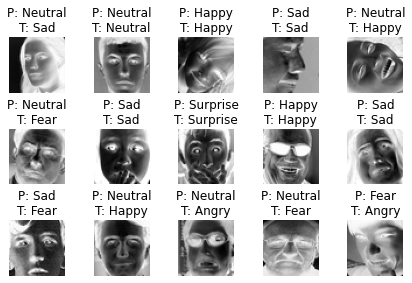

In [ ]:
#Showing test set examples along with predicted labels
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'Angry',
              1: 'Disgust',
              2: 'Fear',
              3: 'Happy',
              4: 'Sad',
              5: 'Surprise',
              6: 'Neutral'}

show_examples(model = model, data_loader = testLoader, unnormalizer = unnormalizer, class_dict = class_dict)

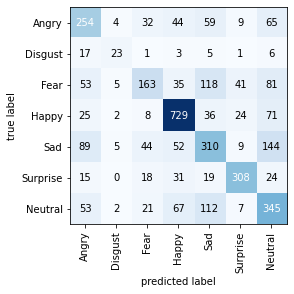

In [ ]:
#Computing and showing Confusion matrix for test set
mat = compute_confusion_matrix(model = model, data_loader = testLoader, device = torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()